In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy import optimize
from matplotlib import cm
from math import isinf
from scipy.optimize import linprog
import random


In [39]:
class NonStationaryBetaEnv:
    def __init__(self, cost, prices, T, seed=None):
        """
        cost: production cost
        prices: list of possible prices (between 0 and 1)
        T: total time steps
        """
        self.cost = cost
        self.prices = np.array(prices)
        self.T = T
        self.rng = np.random.default_rng(seed)
        
        # Precompute rapidly changing alpha/beta params for the Beta distribution
        self.alpha_seq, self.beta_seq = self._generate_nonstationary_params()
        
    def _generate_nonstationary_params(self):
        """
        Generates time-varying alpha and beta parameters for a Beta distribution.
        They oscillate and have random noise so the mean/shape changes quickly.
        """
        t = np.arange(self.T)
        # Fast oscillations between 1 and ~5
        alpha_base = 2.5 + 1.5 * np.sin(0.5 * t) + self.rng.normal(0, 0.2, size=self.T)
        beta_base  = 2.5 + 1.5 * np.sin(0.7 * t + 1.0) + self.rng.normal(0, 0.2, size=self.T)
        
        # Ensure positive
        alpha_base = np.clip(alpha_base, 0.5, None)
        beta_base  = np.clip(beta_base, 0.5, None)
        
        return alpha_base, beta_base
    
    def get_win_probability(self, t, price):
        """
        Probability valuation >= price when valuation ~ Beta(alpha_t, beta_t)
        """
        a_t = self.alpha_seq[t]
        b_t = self.beta_seq[t]
        return 1 - stats.beta.cdf(price, a_t, b_t)
    
    def get_win_probabilities(self, t):
        """Return an array of win probabilities for all prices at time t."""
        return np.array([self.get_win_probability(t, p) for p in self.prices])
    
    def round(self, t, n_customers, price):
        """
        Simulate a round at time t.
        Returns: (demand, revenue)
        """
        win_prob = self.get_win_probability(t, price)
        d_t = self.rng.binomial(n_customers, win_prob)
        r_t = (price - self.cost) * d_t
        return d_t, r_t

In [30]:
class JumpingNormalEnv:
    def __init__(self, cost, prices, T, jump_prob=0.2, seed=None):
        """
        cost: production cost
        prices: list of possible prices (between 0 and 1)
        T: total time steps
        jump_prob: probability of a sudden change in mean valuation at each step
        """
        self.cost = cost
        self.prices = np.array(prices)
        self.T = T
        self.jump_prob = jump_prob
        self.rng = np.random.default_rng(seed)
        
        # Precompute rapidly changing means for valuation distribution
        self.means = self._generate_jumpy_means()
        
    def _generate_jumpy_means(self):
        means = np.empty(self.T)
        mean_val = self.rng.uniform(0.2, 0.8)  # initial mean
        for t in range(self.T):
            # With jump_prob, pick a new random mean between 0 and 1
            if self.rng.random() < self.jump_prob:
                mean_val = self.rng.uniform(0.1, 0.9)
            # Small random walk noise
            mean_val += self.rng.normal(0, 0.02)
            mean_val = np.clip(mean_val, 0.0, 1.0)
            means[t] = mean_val
        return means
    
    def get_win_probability(self, t, price):
        """
        Probability valuation >= price when valuation ~ TruncatedNormal(mean_t, std=0.1)
        """
        mean_t = self.means[t]
        std = 0.1
        # Monte Carlo estimate for truncated [0,1] normal CDF
        samples = np.clip(self.rng.normal(mean_t, std, size=5000), 0, 1)
        return np.mean(samples >= price)
    
    def get_win_probabilities(self, t):
        """Return an array of win probabilities for all prices at time t."""
        return np.clip(
            np.array([self.get_win_probability(t, p) for p in self.prices]),
            0.0, 1.0
        )

    
    def round(self, t, n_customers, price):
        """
        Simulate a round at time t.
        Returns: (demand, revenue)
        """
        win_prob = self.get_win_probability(t, price)
        d_t = self.rng.binomial(n_customers, win_prob)
        r_t = (price - self.cost) * d_t
        return d_t, r_t

In [40]:
class UCBLikeAgent():
    def __init__(self, K, B, T, range=1):
        self.K = K
        self.T = T
        self.range = range
        self.a_t = None # it's an index, not the actual bid
        self.avg_f = np.zeros(K)
        self.avg_c = np.zeros(K)
        self.N_pulls = np.zeros(K)
        self.budget = B
        self.rho = B/T
        self.t = 0
    
    def pull_arm(self):
        if self.budget < 1:
            return -1
        if self.t < self.K:
            self.a_t = self.t 
        else:
            f_ucbs = self.avg_f + self.range*np.sqrt(2*np.log(self.T)/self.N_pulls)
            c_lcbs = self.avg_c - self.range*np.sqrt(2*np.log(self.T)/self.N_pulls)
            gamma_t = self.compute_opt(f_ucbs, c_lcbs)
            self.a_t = np.random.choice(self.K, p=gamma_t)
        return self.a_t

    def compute_opt(self, f_ucbs, c_lcbs):
        # If all arms appear to have zero (or negative) cost lower-bounds,
        # we fall-back to greedy on f_ucbs (but still respect budget by using LP normally).
        if np.all(c_lcbs <= 0):
            gamma = np.zeros(len(f_ucbs))
            gamma[np.argmax(f_ucbs)] = 1.0
            return gamma

        c = -f_ucbs
        A_ub = [c_lcbs]
        b_ub = [self.rho]
        A_eq = [np.ones(self.K)]
        b_eq = [1.0]

        res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq,
                            bounds=[(0,1)]*self.K, method='highs')
        if not res.success:
            # fallback: uniform
            gamma = np.ones(self.K) / self.K
        else:
            gamma = np.maximum(0, res.x)
            s = gamma.sum()
            gamma = gamma / s if s > 0 else np.ones(self.K)/self.K
        return gamma

    
    def update(self, f_t, c_t):
        self.N_pulls[self.a_t] += 1
        self.avg_f[self.a_t] += (f_t - self.avg_f[self.a_t])/self.N_pulls[self.a_t]
        self.avg_c[self.a_t] += (c_t - self.avg_c[self.a_t])/self.N_pulls[self.a_t]
        self.budget -= c_t
        self.t += 1

In [41]:
def compute_clairvoyant(prices, rho, win_probabilities, cost=0.0):
    # maximize expected reward per round: (price-cost)*win_prob
    c = - (prices - cost) * win_probabilities
    A_ub = [win_probabilities]
    b_ub = [rho]
    A_eq = [np.ones(len(prices))]
    b_eq = [1.0]
    res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq,
                           bounds=(0,1), method='highs')
    gamma = res.x
    if not res.success:
    # Fallback: return zeros or uniform distribution
        return None, None
    return gamma, -res.fun


In [44]:
n_t = 1
T = 12000
B = 6500
rho = B/T
epsilon = T**(-0.33)
K = int(1/epsilon)
prices = np.linspace(0,1,K)
n_epochs = 20
all_regrets = []
all_payments = []
all_pulls = []
for i in range(n_epochs):

    agent = UCBLikeAgent(K, B,T, range=1)
    env = NonStationaryBetaEnv(0, prices, T)
    # env = JumpingNormalEnv(0, prices, T)
    utilities = []
    my_prices = []
    my_payments = []
    total_wins = 0
    clairv_util = []

    np.random.seed(i)
    for u in range(T):
        # env.set()
        gamma, exp_clairv_util = compute_clairvoyant(prices, rho, env.get_win_probabilities(u))
        if gamma is None:
            exp_clairv_util = expected_clairvoyant_utility[-1] if len(expected_clairvoyant_utility) else 0
        # interaction
        index = agent.pull_arm()
        if index != -1:
            my_price = prices[index]
            c_t, f_t = env.round(u, n_t, my_price)
            agent.update(f_t, c_t)
        else:
            f_t = 0
            my_price = prices[K-1]
            c_t = 0    
        # logging
        utilities.append(f_t)
        clairv_util.append(exp_clairv_util)
        my_prices.append(my_price)
        my_payments.append(c_t)
        total_wins+=c_t

    utilities = np.array(utilities)
    my_prices = np.array(my_prices)
    my_payments = np.array(my_payments)
    expected_clairvoyant_utility = np.array(clairv_util)
    print(f'Total # of Wins: {total_wins}')
    all_regrets.append(np.cumsum(expected_clairvoyant_utility-utilities))
    all_payments.append(np.cumsum(my_payments))
    all_pulls.append(agent.N_pulls)

avg_regret = np.array(all_regrets).mean(axis=0)
std_regret = np.array(all_regrets).std(axis=0)

avg_payments = np.array(all_payments).mean(axis=0)
std_payments = np.array(all_payments).std(axis=0)

avg_pulls = np.array(all_pulls).mean(axis=0)
std_pulls = np.array(all_pulls).std(axis=0)


Total # of Wins: 6413
Total # of Wins: 6433
Total # of Wins: 6439
Total # of Wins: 6399
Total # of Wins: 6437
Total # of Wins: 6500
Total # of Wins: 6456
Total # of Wins: 6500
Total # of Wins: 6500
Total # of Wins: 6424
Total # of Wins: 6466
Total # of Wins: 6463
Total # of Wins: 6403
Total # of Wins: 6478
Total # of Wins: 6393
Total # of Wins: 6407
Total # of Wins: 6500
Total # of Wins: 6392
Total # of Wins: 6427
Total # of Wins: 6500


<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:21: SyntaxWarning: invalid escape sequence '\s'
<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:21: SyntaxWarning: invalid escape sequence '\s'
C:\Users\digio\AppData\Local\Temp\ipykernel_25404\3233678207.py:12: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sum c_t$')
C:\Users\digio\AppData\Local\Temp\ipykernel_25404\3233678207.py:21: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sum R_t$')


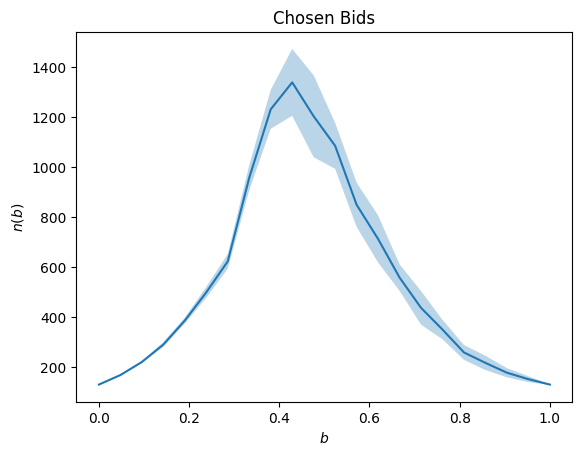

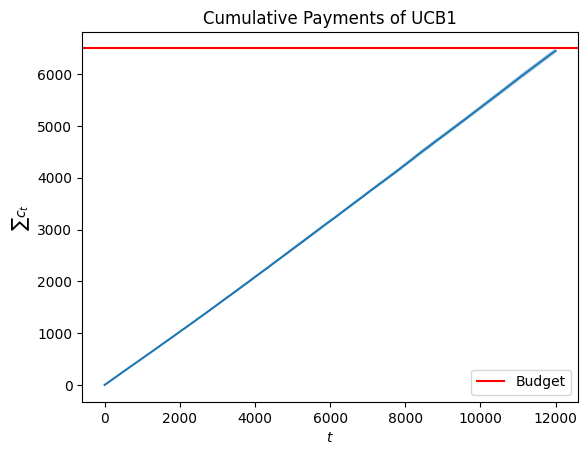

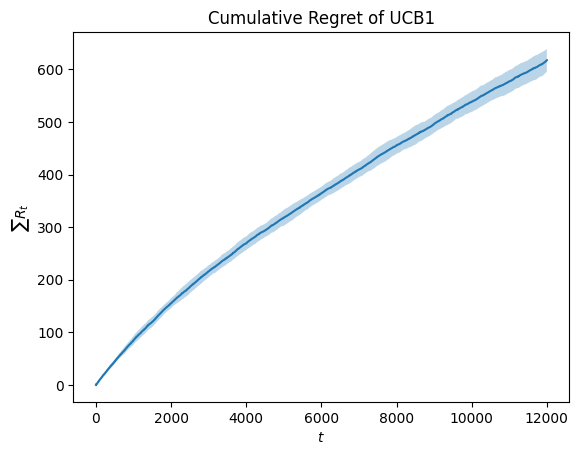

In [46]:
plt.plot(prices, avg_pulls)
plt.fill_between(prices, avg_pulls-std_pulls, avg_pulls+std_pulls, alpha=0.3)
plt.plot()
plt.xlabel('$b$')
plt.ylabel('$n(b)$')
plt.title('Chosen Bids')
plt.show()

plt.plot(np.arange(T), avg_payments)
plt.fill_between(np.arange(T), avg_payments-std_payments, avg_payments+std_payments, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.axhline(B, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments of UCB1')
plt.show()

plt.plot(np.arange(T), avg_regret)
plt.fill_between(np.arange(T), avg_regret-std_regret, avg_regret+std_regret, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum R_t$')
plt.title('Cumulative Regret of UCB1')
plt.show()